In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import seaborn as sns
import scienceplots
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import NullLocator

ROOT_DATA = os.environ.get('LARD_DATA_ROOT_PATH')
ROOT_PROJECT = os.environ.get('LARD_PROJECT_ROOT_PATH')

print(ROOT_DATA)
print(ROOT_PROJECT)

plt.style.use('science')
plt.rcParams['text.usetex'] = False

path_train = f'{ROOT_DATA}/YoloFormat/train_all'  # 统计原始完整训练集
path_test_synth = f'{ROOT_DATA}/YoloFormat/test_synth'
path_test_real_edge = f'{ROOT_DATA}/YoloFormat/test_real_edge'
path_test_real_nominal = f'{ROOT_DATA}/YoloFormat/test_real_nominal'

/fileonssd/lard-dataset
/home/yeli/workspace/lard/lard-detection


# 检查文件数量

In [9]:
def check_image_label_count(dir_path):

    # 构建images和labels的路径
    path_images = os.path.join(dir_path, 'images')
    path_labels = os.path.join(dir_path, 'labels')

    # 检查路径是否存在
    if not os.path.exists(path_images) or not os.path.exists(path_labels):
        print(f"路径 {path_images} 或 {path_labels} 不存在！")
        return

    # 获取两个目录下的文件数量
    num_images = len([f for f in os.listdir(path_images)
                     if os.path.isfile(os.path.join(path_images, f))])
    num_labels = len([f for f in os.listdir(path_labels)
                     if os.path.isfile(os.path.join(path_labels, f))])

    # 打印文件数量
    print(f"在 {dir_path} 中:")
    print(f"图片数量: {num_images}")
    print(f"标签数量: {num_labels}")

    # 判断文件数量是否一致
    if num_images == num_labels:
        print("图片和标签的数量一致。\n")
    else:
        print("警告：图片和标签的数量不一致！\n")


check_image_label_count(path_train)
check_image_label_count(path_test_synth)
check_image_label_count(path_test_real_nominal)
check_image_label_count(path_test_real_edge)


在 /home/yeli/workspace/lard/lard-dataset/YoloFormat/train_all 中:
图片数量: 14433
标签数量: 14433
图片和标签的数量一致。

在 /home/yeli/workspace/lard/lard-dataset/YoloFormat/test_synth 中:
图片数量: 2212
标签数量: 2212
图片和标签的数量一致。

在 /home/yeli/workspace/lard/lard-dataset/YoloFormat/test_real_nominal 中:
图片数量: 1500
标签数量: 1500
图片和标签的数量一致。

在 /home/yeli/workspace/lard/lard-dataset/YoloFormat/test_real_edge 中:
图片数量: 311
标签数量: 311
图片和标签的数量一致。



# 检查标签

In [10]:
def is_label_corrupted(record):

    # 判断记录是否合法
    if record[0] != '0':  # 仅跑道类别
        return True
    for ele in record[1:]:
        if float(ele) < 0.0 or float(ele) > 1.0:  # 归一化坐标
            return True
    return False


def check_labels(path):

    # 判断数据集全部label是否合法
    path = os.path.join(path, "labels")
    filenames = os.listdir(path)
    num_runway_list = []
    corrupted_file = []

    for file in tqdm(filenames):

        with open(os.path.join(path, file), 'r') as f:
            lines = f.readlines()
            for line in lines:
                record = line.strip().split()
                if is_label_corrupted(record):
                    # raise ValueError("类别异常或归一化坐标超限")
                    corrupted_file.append(file)

        num_runway = len(lines)
        num_runway_list.append(num_runway)

        if num_runway != 1:
            raise ValueError(f"文件{file}, 包含{num_runway}条跑道")

    if all(element == 1 for element in num_runway_list):
        print("每个样本只包含1条跑道")
    if corrupted_file:
        print(f"损坏文件共计{len(corrupted_file)}个: {corrupted_file}")
        for file in corrupted_file:
            with open(os.path.join(path, file), 'r') as f:
                lines = f.readlines()
                print(lines)


# 遍历全部label
check_labels(path_train)
check_labels(path_test_synth)
check_labels(path_test_real_nominal)
check_labels(path_test_real_edge)


100%|██████████| 14433/14433 [00:00<00:00, 41625.11it/s]


每个样本只包含1条跑道
损坏文件共计2个: ['VABB_32_500_448.txt', 'LWSK_34_500_132.txt']
['0 0.5161356209150327 0.58740234375 1.0314542483660132 0.5341796875\n']
['0 1.0204248366013071 0.474853515625 0.03104575163398693 0.05419921875\n']


100%|██████████| 2212/2212 [00:00<00:00, 42934.69it/s]


每个样本只包含1条跑道


100%|██████████| 1500/1500 [00:00<00:00, 41238.95it/s]


每个样本只包含1条跑道


100%|██████████| 311/311 [00:00<00:00, 38291.22it/s]

每个样本只包含1条跑道


# 检查图像

In [11]:
def check_imgs(path, is_synth=False):

    path = os.path.join(path, "images")

    filenames = os.listdir(path)

    w_list = []
    h_list = []
    mode_list = []

    for file in tqdm(filenames):

        img = Image.open(os.path.join(path, file))

        # 合成图像分辨率和通道均一致
        if is_synth:
            if img.size != (2448, 2048):  # [宽，高]
                print(img.size)
            if img.mode != 'RGB':
                print(img.mode)

        w_list.append(img.size[0])
        h_list.append(img.size[1])
        mode_list.append(img.mode)

    df_stat = pd.DataFrame({
        'width': w_list,
        'height': h_list,
        'mode':  mode_list
    })
    display(df_stat.groupby(['width', 'height']).count())


# 统计图像分辨率和通道
# 无输出：每个样本图像分辨率均为(2448, 2048, 3)
check_imgs(path_train, is_synth=True)
check_imgs(path_test_synth, is_synth=True)
check_imgs(path_test_real_nominal)
check_imgs(path_test_real_edge)


100%|██████████| 14433/14433 [00:01<00:00, 13155.17it/s]


,,mode
width,height,
2448,2048,14433


100%|██████████| 2212/2212 [00:00<00:00, 13159.46it/s]


,,mode
width,height,
2448,2048,2212


100%|██████████| 1500/1500 [00:00<00:00, 18191.86it/s]


,,mode
width,height,
1280,720,96
1902,1080,19
1918,1080,7
1920,1080,628
3840,2160,750


100%|██████████| 311/311 [00:00<00:00, 17651.50it/s]


,,mode
width,height,
1280,720,24
1920,1080,109
3840,2160,178


# 计算Bbox

In [12]:
def read_yolo_labels(label_file_path):

    # 读取yolo格式标签
    with open(label_file_path, 'r') as f:
        lines = f.readlines()

    labels = []
    for line in lines:
        parts = line.strip().split()
        label = {
            'class': parts[0],
            'x_center': float(parts[1]),
            'y_center': float(parts[2]),
            'width': float(parts[3]),
            'height': float(parts[4])
        }
        labels.append(label)

    return labels


def cal_bbox(image_path, labels):

    # 计算一个bbox的属性
    image = Image.open(image_path)  # image.size (width, height)

    if len(labels) == 1:
        for label in labels:

            # 坐标
            # x_center = int(label['x_center'] * image.size[0])
            # y_center = int(label['y_center'] * image.size[1])

            # 归一化坐标
            x_center = label['x_center']
            y_center = label['y_center']

            # 宽高
            width = int(label['width'] * image.size[0])
            height = int(label['height'] * image.size[1])

            # 面积和宽高比
            area = width * height
            area_percent = area / (image.size[0] * image.size[1])
            ratio = height / width

            return area, area_percent, ratio, x_center, y_center, width, height
    else:
        raise ValueError("目标多于一个！！！")


def get_bbox_info(path):

    # 获取全部bbox属性
    all_area = []
    all_area_percent = []
    all_ratio = []
    all_x_center = []
    all_y_center = []
    all_w = []
    all_h = []

    path_label = os.path.join(path, "labels")
    path_img = os.path.join(path, "images")

    extension = ".jpeg" if path.find("real") == -1 else ".png"  # real图像格式为png

    # 遍历所有label
    filenames = os.listdir(path_label)
    for file in tqdm(filenames):

        label_file_path = os.path.join(path_label, file)
        image_path = os.path.join(path_img, file.split('.txt')[0]+extension)

        labels = read_yolo_labels(label_file_path)
        area, area_percent, ratio, x_center, y_center, width, height = cal_bbox(
            image_path, labels)

        all_area.append(area)
        all_area_percent.append(area_percent)
        all_ratio.append(ratio)
        all_x_center.append(x_center)
        all_y_center.append(y_center)
        all_w.append(width)
        all_h.append(height)

    # 重构数据为np.array
    all_area = np.array(all_area)
    all_area_percent = np.array(all_area_percent)
    all_ratio = np.array(all_ratio)
    all_x_center = np.array(all_x_center)
    all_y_center = np.array(all_y_center)
    all_w = np.array(all_w)
    all_h = np.array(all_h)

    return all_area, all_area_percent, all_ratio, all_x_center, all_y_center, all_w, all_h


# 统计各数据集
area_train, area_train_percent, ratio_train, x_center_train, y_center_train, w_train, h_train = get_bbox_info(
    path_train)
area_test_synth, area_test_synth_percent, ratio_test_synth, x_center_test_synth, y_center_test_synth, _, _ = get_bbox_info(
    path_test_synth)
area_test_real_nominal, area_test_real_edge_percent, ratio_test_real_nominal, x_center_test_real_nominal, y_center_test_real_nominal, _, _ = get_bbox_info(
    path_test_real_nominal)
area_test_real_edge, area_test_real_edge_percent, ratio_test_real_edge, x_center_test_real_edge, y_center_test_real_edge, _, _ = get_bbox_info(
    path_test_real_edge)


100%|██████████| 311/311 [00:00<00:00, 17250.92it/s]


In [13]:
# # 训练集bbox宽高分布
# # 尺寸归一化到 Yolo输入尺度
# imgsz = 640
# w_train_n = w_train/2448 * imgsz
# h_train_n = h_train/2048 * imgsz

# print(w_train_n.max(), w_train_n.min(), w_train_n.mean())
# print(h_train_n.max(), h_train_n.min(), h_train_n.mean())

# fig, axes = plt.subplots(1, 1, figsize=(6, 4), dpi=100)

# sns.scatterplot(x=w_train_n, y=h_train_n, ax=axes)
# sns.kdeplot(x=w_train_n, y=h_train_n, ax=axes)
# axes.set_xlim([0, imgsz])
# axes.set_ylim([0, imgsz])
# axes.set_aspect('equal')
# plt.tight_layout()
# plt.show()

# Bbox面积占比/宽高比

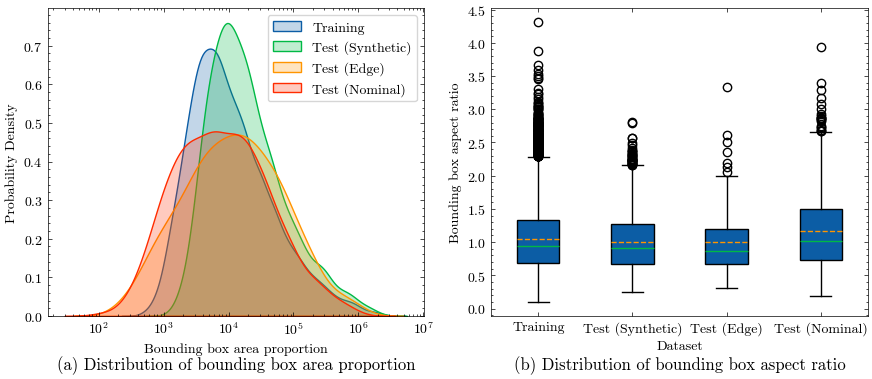

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4), dpi=100)

# 面积比例分布图
is_log = True
sns.kdeplot(area_train, label="Training",
            log_scale=is_log, fill=True, ax=axes[0])
sns.kdeplot(area_test_synth, label="Test (Synthetic)",
            log_scale=is_log, fill=True, ax=axes[0])
sns.kdeplot(area_test_real_edge, label="Test (Edge)",
            log_scale=is_log, fill=True, ax=axes[0])
sns.kdeplot(area_test_real_nominal, label="Test (Nominal)",
            log_scale=is_log, fill=True, ax=axes[0])

# 均值直线 # todo: 注意颜色需要修改
# axes[0].axvline(x=area_train.mean(), color='red',
#                 linestyle='dashed', label='Training mean')
# axes[0].axvline(x=area_test_synth.mean(), color='orange',
#                 linestyle='dashed', label='Test (Synthetic) mean')
# axes[0].axvline(x=area_test_real_edge.mean(), color='blue',
#                 linestyle='dashed', label='Test (Edge) mean')
# axes[0].axvline(x=area_test_real_nominal.mean(), color='yellow',
#                 linestyle='dashed', label='Test (Nominal) mean')

# 宽高比分布图
axes[1].boxplot(
    [ratio_train, ratio_test_synth, ratio_test_real_edge, ratio_test_real_nominal],
    meanline=True,
    showmeans=True,
    patch_artist=True,
    labels=['Training', "Test (Synthetic)", "Test (Edge)", "Test (Nominal)"])

axes[0].set_xlabel("Bounding box area proportion")
axes[0].set_ylabel("Probability Density")
axes[0].legend(loc='best', frameon=True)

axes[1].set_xlabel("Dataset")
axes[1].set_ylabel("Bounding box aspect ratio")
axes[1].yaxis.set_major_locator(MultipleLocator(0.5))
axes[1].tick_params(axis='x', which='both', top=True, bottom=True)
axes[1].xaxis.set_minor_locator(NullLocator())

axes[0].set_title('(a) Distribution of bounding box area proportion', y=-0.2)
axes[1].set_title('(b) Distribution of bounding box aspect ratio', y=-0.2)

plt.tight_layout()
plt.savefig(
    f'{ROOT_PROJECT}/results/figs/eda/distribution_of_bbox.jpg',
    dpi=600, bbox_inches='tight')  # pad_inches=0.0
plt.show()

# bbox中心坐标分布

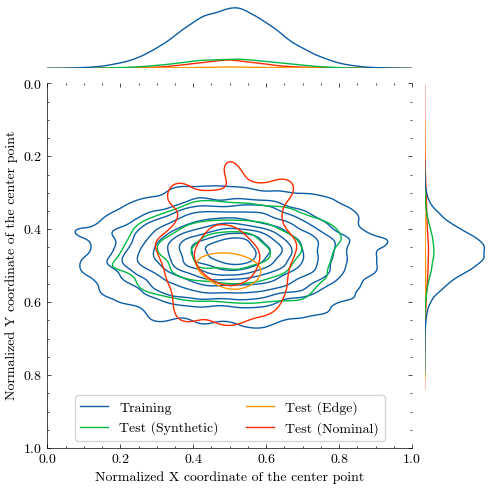

In [15]:
data_train = {
    'x_center': x_center_train,
    'y_center': y_center_train,
    'dataset': ['Training' for _ in range(len(x_center_train))]
}
data_test_synth = {
    'x_center': x_center_test_synth,
    'y_center': y_center_test_synth,
    'dataset': ['Test (Synthetic)' for _ in range(len(x_center_test_synth))]
}
data_test_real_edge = {
    'x_center': x_center_test_real_edge,
    'y_center': y_center_test_real_edge,
    'dataset': ['Test (Edge)' for _ in range(len(x_center_test_real_edge))]
}
data_test_real_nominal = {
    'x_center': x_center_test_real_nominal,
    'y_center': y_center_test_real_nominal,
    'dataset': ['Test (Nominal)' for _ in range(len(x_center_test_real_nominal))]
}

data_train = pd.DataFrame(data_train)
data_test_synth = pd.DataFrame(data_test_synth)
data_test_real_edge = pd.DataFrame(data_test_real_edge)
data_test_real_nominal = pd.DataFrame(data_test_real_nominal)
data = pd.concat([data_train, data_test_synth, data_test_real_edge,
                 data_test_real_nominal], ignore_index=True)

# 绘制联合分布图
g = sns.jointplot(
    data=data,
    x="x_center",
    y="y_center",
    hue="dataset",
    kind="kde",
    xlim=[0, 1],
    ylim=[0, 1],
)
g.ax_joint.set_xlabel("Normalized X coordinate of the center point")
g.ax_joint.set_ylabel("Normalized Y coordinate of the center point")

g.fig.set_size_inches(5, 5)
g.fig.set_dpi(100)
g.ax_joint.invert_yaxis()
g.ax_joint.set_aspect('equal')
g.ax_marg_x.set_axis_off()
g.ax_marg_y.set_axis_off()
sns.move_legend(g.ax_joint, frameon=True,
                loc='lower center', ncols=2, title='')

plt.savefig(
    f'{ROOT_PROJECT}/results/figs/eda/distribution_of_bbox_center.jpg',
    dpi=600, bbox_inches='tight')  # pad_inches=0.0
plt.show()


# 目标尺寸统计

findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

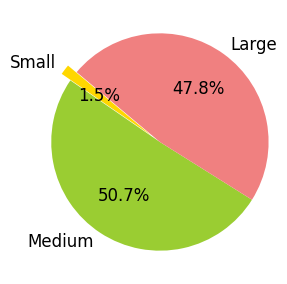

Total objects: 14433
Small objects: 220 (1.52%)
Medium objects: 7313 (50.67%)
Large objects: 6900 (47.81%)


: 

In [16]:
import json
import matplotlib.pyplot as plt

plt.style.use('classic')
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"]

# 计数变量
small_count = 0
medium_count = 0
large_count = 0

# 加载标注文件
with open(f'{ROOT_DATA}/annotations/instances_train_all.json', 'r') as f:
    annotations = json.load(f)

# 遍历所有标注
for ann in annotations['annotations']:
    bbox = ann['bbox']  # 假设使用 COCO 格式的 [x,y,width,height]
    area = bbox[2] * bbox[3]

    # 判断目标大小
    if area <= 32 ** 2:
        small_count += 1
    elif area <= 96 ** 2:
        medium_count += 1
    else:
        large_count += 1

# 目标总数
total_count = small_count + medium_count + large_count

# 计算占比
small_prop = (small_count / total_count) * 100
medium_prop = (medium_count / total_count) * 100
large_prop = (large_count / total_count) * 100

# 构造饼图
labels = 'Small', 'Medium', 'Large'
sizes = [small_count, medium_count, large_count]
colors = ['gold', 'yellowgreen', 'lightcoral']
explode = (0.1, 0, 0)  # explode the 1st slice

# 绘图
plt.figure(figsize=(3, 3), facecolor='white', dpi=100)
plt.pie(
    sizes, explode=explode, labels=labels, colors=colors,
    autopct='%1.1f%%', shadow=False, startangle=140,
    wedgeprops={'linewidth': 0, 'edgecolor': 'green'},
    textprops={'fontsize': 12, 'color': 'k', 'fontfamily': 'serif'})
plt.axis('equal')
plt.tight_layout()
plt.savefig(
    f'{ROOT_PROJECT}/results/figs/eda/pie_of_object_sizes.jpg',
    dpi=600, bbox_inches='tight')  # pad_inches=0.0
plt.show()

print(f"Total objects: {total_count}")
print(f"Small objects: {small_count} ({small_prop:.2f}%)")
print(f"Medium objects: {medium_count} ({medium_prop:.2f}%)")
print(f"Large objects: {large_count} ({large_prop:.2f}%)")